# Pengembangan Model Machine Learning untuk Prediksi Thermal Comfort

## Setup Awal
### Instalasi library yang diperlukan

In [1]:
'''!pip install scikeras
!pip install xgboost
!pip install pythermalcomfort'''

'!pip install scikeras\n!pip install xgboost\n!pip install pythermalcomfort'

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from scipy.stats import randint, uniform, loguniform
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import random
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import joblib
import os 

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

warnings.filterwarnings('ignore')

### Load Data

In [4]:

# Baca dataset
data = pd.read_csv('cleaned_data_pmv.csv')
features = ["temperature", "humidity", "air_flow", "mrt"]
target = "pmv"


In [5]:
X = data[features]
y = data[target]

### Split Data dan Normalisasi

In [6]:

# Split 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifikasi ukuran masing-masing set
print(f"Train size: {len(X_train)/len(X):.2%}")
print(f"Test size: {len(X_test)/len(X):.2%}")


Train size: 80.00%
Test size: 20.00%


In [7]:
# Normalisasi
scaler = MinMaxScaler()

# Fit scaler hanya pada X_train, dan transform X_train, dan X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verifikasi ukuran masing-masing set setelah normalisasi
print(f"Train size: {len(X_train_scaled)/len(X):.2%}")
print(f"Test size: {len(X_test_scaled)/len(X):.2%}")


Train size: 80.00%
Test size: 20.00%


## Modeling

### Fungsi Evaluasi

In [8]:
# Fungsi evaluasi
def evaluate(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name):
    df = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'MAE': [
            mean_absolute_error(y_train_true, y_train_pred),
            mean_absolute_error(y_test_true, y_test_pred)
        ],
        'RMSE': [
            np.sqrt(mean_squared_error(y_train_true, y_train_pred)),
            np.sqrt(mean_squared_error(y_test_true, y_test_pred))
        ],
        'R2': [
            r2_score(y_train_true, y_train_pred),
            r2_score(y_test_true, y_test_pred)
        ]
    })

    print(f"\n=== {model_name} ===")
    print(df.to_string(index=False))

    return df


### 1. K - Nearest Neighbor (KNN)

In [9]:
# 1. KNN - Grid Search Terbaik
print("\n=== Tuning KNN (Grid Search) ===")
knn_params = {
    'n_neighbors': range(3,19,2),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    knn_params,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

knn_grid.fit(X_train_scaled, y_train)
print("[KNN] Best Parameters:", knn_grid.best_params_)
print(f"[KNN] Best Paramters MAE:, {-knn_grid.best_score_:.4f}")



=== Tuning KNN (Grid Search) ===
[KNN] Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3}
[KNN] Best Paramters MAE:, 0.0263


In [10]:
# Menampilkan hasil cross-validation (validasi) untuk setiap kombinasi parameter
cv_results = knn_grid.cv_results_

# Menampilkan hasil MAE untuk tiap kombinasi parameter
print("\n=== Cross-Validation Results (MAE) ===")
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    # Mengonversi nilai negative MAE ke MAE positif
    mean_mae = -mean_score
    print(f"Params: {params}, Mean Test MAE: {mean_mae:.4f}")


=== Cross-Validation Results (MAE) ===
Params: {'metric': 'euclidean', 'n_neighbors': 3}, Mean Test MAE: 0.0263
Params: {'metric': 'euclidean', 'n_neighbors': 5}, Mean Test MAE: 0.0281
Params: {'metric': 'euclidean', 'n_neighbors': 7}, Mean Test MAE: 0.0296
Params: {'metric': 'euclidean', 'n_neighbors': 9}, Mean Test MAE: 0.0308
Params: {'metric': 'euclidean', 'n_neighbors': 11}, Mean Test MAE: 0.0317
Params: {'metric': 'euclidean', 'n_neighbors': 13}, Mean Test MAE: 0.0324
Params: {'metric': 'euclidean', 'n_neighbors': 15}, Mean Test MAE: 0.0330
Params: {'metric': 'euclidean', 'n_neighbors': 17}, Mean Test MAE: 0.0337
Params: {'metric': 'manhattan', 'n_neighbors': 3}, Mean Test MAE: 0.0268
Params: {'metric': 'manhattan', 'n_neighbors': 5}, Mean Test MAE: 0.0287
Params: {'metric': 'manhattan', 'n_neighbors': 7}, Mean Test MAE: 0.0304
Params: {'metric': 'manhattan', 'n_neighbors': 9}, Mean Test MAE: 0.0316
Params: {'metric': 'manhattan', 'n_neighbors': 11}, Mean Test MAE: 0.0324
Params

In [11]:
# Evaluation
best_knn = knn_grid.best_estimator_
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

# Evaluasi hasil model
knn_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "KNN BEST MODEL")


=== KNN BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.015433 0.031024 0.998454
   Test 0.024186 0.048732 0.996186


### 2. Random Forest

In [12]:

# 2. Random Forest - Grid Search Terbaik
print("\n=== Tuning Random Forest (Grid Search) ===")

rf_params_grid = {
    'n_estimators': [100, 500],
    'max_depth': [5, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_params_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=1
)

# Melakukan Grid Search
rf_grid.fit(X_train_scaled, y_train)

# Menampilkan parameter terbaik yang ditemukan
print("[Random Forest] Best Parameters (Grid Search):", rf_grid.best_params_)
print(f"[Random Forest] Best Paramters MAE:, {-rf_grid.best_score_:.4f}")


=== Tuning Random Forest (Grid Search) ===
Fitting 5 folds for each of 96 candidates, totalling 480 fits


OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [ ]:
# Menampilkan hasil cross-validation (validasi) untuk setiap kombinasi parameter
cv_results = rf_grid.cv_results_

# Menampilkan hasil MAE untuk tiap kombinasi parameter
print("\n=== Cross-Validation Results (MAE) ===")
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    # Mengonversi nilai negative MAE ke MAE positif
    mean_mae = -mean_score
    print(f"Params: {params}, Mean Test MAE: {mean_mae:.4f}")


=== Cross-Validation Results (MAE) ===
Params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}, Mean Test MAE: nan
Params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}, Mean Test MAE: nan
Params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}, Mean Test MAE: nan
Params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}, Mean Test MAE: nan
Params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}, Mean Test MAE: nan
Params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 500}, Mean Test MAE: nan
Params: {'bootstrap': 

In [ ]:
# Evaluation
best_rf = rf_grid.best_estimator_
y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

# Evaluasi hasil model
rf_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "RF BEST MODEL")


=== RF BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.004487 0.011422 0.999790
   Test 0.012830 0.032397 0.998314


### 3. Support Vector Regression

In [ ]:
# 3. SVR - Grid Search Terbaik
print("\n=== Tuning SVR (Grid Search) ===")
svr_params = {
    'C': [0.1, 1],
    'epsilon': [0.1, 1],
    'kernel': ['rbf', 'linear', 'poly'],
}

svr_grid = GridSearchCV(
    SVR(),
    svr_params,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=1
)

svr_grid.fit(X_train_scaled, y_train)
print("[SVR] Best Parameters:", svr_grid.best_params_)
print(f"[SVR] Best Paramters MAE:, {-svr_grid.best_score_:.4f}")


=== Tuning SVR (Grid Search) ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[SVR] Best Parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
[SVR] Best Paramters MAE:, 0.0411


In [ ]:
# Menampilkan hasil cross-validation (validasi) untuk setiap kombinasi parameter
cv_results = svr_grid.cv_results_

# Menampilkan hasil MAE untuk tiap kombinasi parameter
print("\n=== Cross-Validation Results (MAE) ===")
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    mean_mae = -mean_score
    print(f"Params: {params}, Mean Test MAE: {mean_mae:.4f}")



=== Cross-Validation Results (MAE) ===
Params: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}, Mean Test MAE: 0.0457
Params: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}, Mean Test MAE: 0.0593
Params: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}, Mean Test MAE: 0.1358
Params: {'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}, Mean Test MAE: 0.3164
Params: {'C': 0.1, 'epsilon': 1, 'kernel': 'linear'}, Mean Test MAE: 0.2389
Params: {'C': 0.1, 'epsilon': 1, 'kernel': 'poly'}, Mean Test MAE: 0.5758
Params: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}, Mean Test MAE: 0.0411
Params: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}, Mean Test MAE: 0.0584
Params: {'C': 1, 'epsilon': 0.1, 'kernel': 'poly'}, Mean Test MAE: 0.1353
Params: {'C': 1, 'epsilon': 1, 'kernel': 'rbf'}, Mean Test MAE: 0.3986
Params: {'C': 1, 'epsilon': 1, 'kernel': 'linear'}, Mean Test MAE: 0.1972
Params: {'C': 1, 'epsilon': 1, 'kernel': 'poly'}, Mean Test MAE: 0.5936


In [ ]:
# Evaluation
best_svr = svr_grid.best_estimator_
y_train_pred = best_svr.predict(X_train_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

# Evaluasi hasil model
svr_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "SVR BEST MODEL")



=== SVR BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.040188 0.048333 0.996248
   Test 0.040223 0.048719 0.996188


### 4. XGBoost Regressor

In [ ]:
# 4. XGBoost - Grid Search Terbaik
print("\n=== Tuning XGBoost (Grid Search) ===")

# Mendefinisikan parameter yang akan dicari
xgb_params_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

# GridSearchCV dengan model XGBoost
xgb_grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=xgb_params_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=1
)

# Melakukan pencarian parameter terbaik
xgb_grid.fit(X_train_scaled, y_train)
print("[XGBoost] Best Parameters (Grid Search):", xgb_grid.best_params_)
print(f"[XGBoost] Best Paramters MAE:, {-xgb_grid.best_score_:.4f}")



=== Tuning XGBoost (Grid Search) ===
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[XGBoost] Best Parameters (Grid Search): {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
[XGBoost] Best Paramters MAE:, 0.0086


In [ ]:
# Menampilkan hasil cross-validation (validasi) untuk setiap kombinasi parameter
cv_results = xgb_grid.cv_results_

# Menampilkan hasil MAE untuk tiap kombinasi parameter
print("\n=== Cross-Validation Results (MAE) ===")
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    # Mengonversi nilai negative MAE ke MAE positif
    mean_mae = -mean_score
    print(f"Params: {params}, Mean Test MAE: {mean_mae:.4f}")



=== Cross-Validation Results (MAE) ===
Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}, Mean Test MAE: 0.0512
Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}, Mean Test MAE: 0.0509
Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}, Mean Test MAE: 0.0515
Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 1.0}, Mean Test MAE: 0.0511
Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.1, '

In [ ]:
# Mendapatkan model terbaik
best_xgb = xgb_grid.best_estimator_

# Prediksi menggunakan model terbaik
y_train_pred = best_xgb.predict(X_train_scaled)
y_test_pred = best_xgb.predict(X_test_scaled)

# Evaluasi hasil model
xgb_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "XGBoost BEST MODEL")


=== XGBoost BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.003243 0.004470 0.999968
   Test 0.008014 0.022156 0.999212


### 5. Multilayer Perceptron (MLP)

In [ ]:
# 5. MLP - Hyperparameter Tuning
print("\n=== Manual Tuning MLP Berdasarkan Batch Size dan Epochs ===")

# Fungsi build model
def build_mlp(hidden_1=256, hidden_2=128, hidden_3=64, hidden_4=32, dropout_rate=0.2, learning_rate=0.001):
  model = Sequential([
        Dense(hidden_1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout_rate),
        Dense(hidden_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_3, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_4, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')
  return model

# Kombinasi yang diuji
batch_sizes = [32, 64, 128]
epoch_list = [100, 200]

# Simpan hasil evaluasi
results = {}

for batch_size in batch_sizes:
    for epochs in epoch_list:
        print(f"\nTraining MLP dengan batch_size={batch_size}, epochs={epochs}...")

        model = build_mlp()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(
            X_train_scaled, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0,
            callbacks=[early_stopping]
        )

        # Predict
        y_train_pred = model.predict(X_train_scaled).flatten()
        y_test_pred = model.predict(X_test_scaled).flatten()

        # Evaluasi
        result = evaluate(y_train, y_train_pred, y_test, y_test_pred,
                          f"MLP (Batch {batch_size}, Epochs {epochs})")

        # Simpan ke dictionary
        results[(batch_size, epochs)] = {
            'Train MAE': result['MAE'][0],
            'Test MAE': result['MAE'][1],
            'Train RMSE': result['RMSE'][0],
            'Test RMSE': result['RMSE'][1],
            'Train R2': result['R2'][0],
            'Test R2': result['R2'][1]
        }

# Ubah results jadi DataFrame
mlp_results = pd.DataFrame([
    {
        'Batch Size': batch_size,
        'Epochs': epochs,
        **metrics
    }
    for (batch_size, epochs), metrics in results.items()
])

print("\n=== Hasil Semua Kombinasi MLP ===")
print(mlp_results)



=== Manual Tuning MLP Berdasarkan Batch Size dan Epochs ===

Training MLP dengan batch_size=32, epochs=100...
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== MLP (Batch 32, Epochs 100) ===
Dataset     MAE     RMSE       R2
  Train 0.02418 0.037479 0.997744
   Test 0.02466 0.038547 0.997614

Training MLP dengan batch_size=32, epochs=200...
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== MLP (Batch 32, Epochs 200) ===
Dataset      MAE     RMSE       R2
  Train 0.030077 0.042585 0.997087
   Test 0.030171 0.043078 0.997020

Training MLP dengan batch_size=64, epochs=100...
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== MLP (Batch 64, Epochs 100) ===
Dataset      MAE     RMSE       R2
  Train 0.028095 0.038582 0.997609
   Test 0.028224 0.038916 0.997568

Training MLP dengan batch_size=64, epochs=200...
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
253/253 ━━━━━━━━━━━━━━━━

In [ ]:
# Cari kombinasi terbaik berdasarkan Test MAE (semakin kecil semakin bagus)
best_mlp = mlp_results.loc[mlp_results['Test MAE'].idxmin()]

print("\n=== Kombinasi MLP Terbaik berdasarkan Test MAE ===")
print(best_mlp)

# Format hasil akhir untuk digabung ke all_results
mlp_results = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'MAE': [best_mlp['Train MAE'], best_mlp['Test MAE']],
    'RMSE': [best_mlp['Train RMSE'], best_mlp['Test RMSE']],
    'R2': [best_mlp['Train R2'], best_mlp['Test R2']],
    'Model': 'MLP'
})

print("\n=== Hasil Akhir MLP ===")
print(mlp_results)


=== Kombinasi MLP Terbaik berdasarkan Test MAE ===
Batch Size     32.000000
Epochs        100.000000
Train MAE       0.024180
Test MAE        0.024660
Train RMSE      0.037479
Test RMSE       0.038547
Train R2        0.997744
Test R2         0.997614
Name: 0, dtype: float64

=== Hasil Akhir MLP ===
  Dataset      MAE      RMSE        R2 Model
0   Train  0.02418  0.037479  0.997744   MLP
1    Test  0.02466  0.038547  0.997614   MLP


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction_comparison(y_true, y_pred, model_name, dataset_name='Test'):
    plt.figure(figsize=(12, 5))

    # === Plot 1: Scatter plot ===
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, color='mediumseagreen', s=20)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual PMV')
    plt.ylabel('Predicted PMV')
    plt.title(f'{model_name} - {dataset_name} Set\nScatter Prediksi vs Aktual')
    plt.grid(True)

    # === Plot 2: Line plot semua data test ===
    plt.subplot(1, 2, 2)
    x = np.arange(len(y_true))
    plt.plot(x, y_true, 'bo-', label='Actual')
    plt.plot(x, y_pred, 'rx--', label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('PMV')
    plt.title(f'{model_name} - {dataset_name} Set\nPrediksi vs Aktual (Semua Data)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Evaluation

In [ ]:

# Menambahkan nama model ke hasil evaluasi masing-masing
knn_results['Model'] = 'KNN'
rf_results['Model'] = 'Random Forest'
svr_results['Model'] = 'SVR'
xgb_results['Model'] = 'XGBoost'
mlp_results['Model'] = 'MLP'

# Gabungkan semua hasil evaluasi
all_results = pd.concat([knn_results, rf_results, svr_results, xgb_results, mlp_results], ignore_index=True)


### Tabel Perbandingan Seluruh Model

In [ ]:
# === Membandingkan Semua Model Secara Lengkap ===

# 1. Train Set - Berdasarkan MAE
print("\n=== PERBANDINGAN TRAIN SET BERDASARKAN MAE (Semakin kecil semakin bagus) ===")
train_results = all_results[all_results['Dataset'] == 'Train']
print(train_results.sort_values('MAE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 2. Train Set - Berdasarkan RMSE
print("\n=== PERBANDINGAN TRAIN SET BERDASARKAN RMSE (Semakin kecil semakin bagus) ===")
print(train_results.sort_values('RMSE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 3. Train Set - Berdasarkan R2 Score (Semakin tinggi semakin bagus)
print("\n=== PERBANDINGAN TRAIN SET BERDASARKAN R2 (Semakin tinggi semakin bagus) ===")
print(train_results.sort_values('R2', ascending=False)[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

test_results = all_results[all_results['Dataset'] == 'Test']
# 4. Test Set - Berdasarkan MAE
print("\n=== PERBANDINGAN TEST SET BERDASARKAN MAE (Semakin kecil semakin bagus) ===")
print(test_results.sort_values('MAE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 5. Test Set - Berdasarkan RMSE
print("\n=== PERBANDINGAN TEST SET BERDASARKAN RMSE (Semakin kecil semakin bagus) ===")
print(test_results.sort_values('RMSE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 6. Test Set - Berdasarkan R2 Score (Semakin tinggi semakin bagus)
print("\n=== PERBANDINGAN TEST SET BERDASARKAN R2 (Semakin tinggi semakin bagus) ===")
print(test_results.sort_values('R2', ascending=False)[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))



=== PERBANDINGAN TRAIN SET BERDASARKAN MAE (Semakin kecil semakin bagus) ===
        Model      MAE     RMSE       R2
      XGBoost 0.003243 0.004470 0.999968
Random Forest 0.004487 0.011422 0.999790
          KNN 0.015432 0.031023 0.998454
          MLP 0.024180 0.037479 0.997744
          SVR 0.040188 0.048333 0.996248

=== PERBANDINGAN TRAIN SET BERDASARKAN RMSE (Semakin kecil semakin bagus) ===
        Model      MAE     RMSE       R2
      XGBoost 0.003243 0.004470 0.999968
Random Forest 0.004487 0.011422 0.999790
          KNN 0.015432 0.031023 0.998454
          MLP 0.024180 0.037479 0.997744
          SVR 0.040188 0.048333 0.996248

=== PERBANDINGAN TRAIN SET BERDASARKAN R2 (Semakin tinggi semakin bagus) ===
        Model      MAE     RMSE       R2
      XGBoost 0.003243 0.004470 0.999968
Random Forest 0.004487 0.011422 0.999790
          KNN 0.015432 0.031023 0.998454
          MLP 0.024180 0.037479 0.997744
          SVR 0.040188 0.048333 0.996248

=== PERBANDINGAN TEST SET 

In [ ]:
# Mencari model terbaik berdasarkan masing-masing metrik
best_mae_model = test_results.loc[test_results['MAE'].idxmin()]
best_rmse_model = test_results.loc[test_results['RMSE'].idxmin()]
best_r2_model   = test_results.loc[test_results['R2'].idxmax()]

print("\n=== MODEL DENGAN MAE TERKECIL (Test Set) ===")
print(best_mae_model)

print("\n=== MODEL DENGAN RMSE TERKECIL (Test Set) ===")
print(best_rmse_model)

print("\n=== MODEL DENGAN R2 TERTINGGI (Test Set) ===")
print(best_r2_model)



=== MODEL DENGAN MAE TERKECIL (Test Set) ===
Dataset        Test
MAE        0.008014
RMSE       0.022156
R2         0.999212
Model       XGBoost
Name: 7, dtype: object

=== MODEL DENGAN RMSE TERKECIL (Test Set) ===
Dataset        Test
MAE        0.008014
RMSE       0.022156
R2         0.999212
Model       XGBoost
Name: 7, dtype: object

=== MODEL DENGAN R2 TERTINGGI (Test Set) ===
Dataset        Test
MAE        0.008014
RMSE       0.022156
R2         0.999212
Model       XGBoost
Name: 7, dtype: object


### Grafik Visualisasi

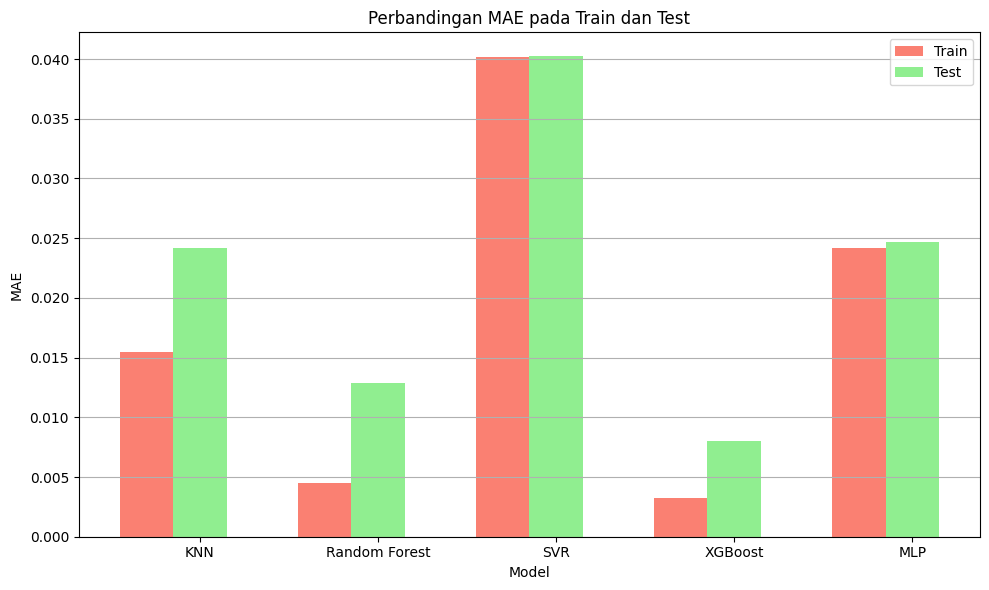

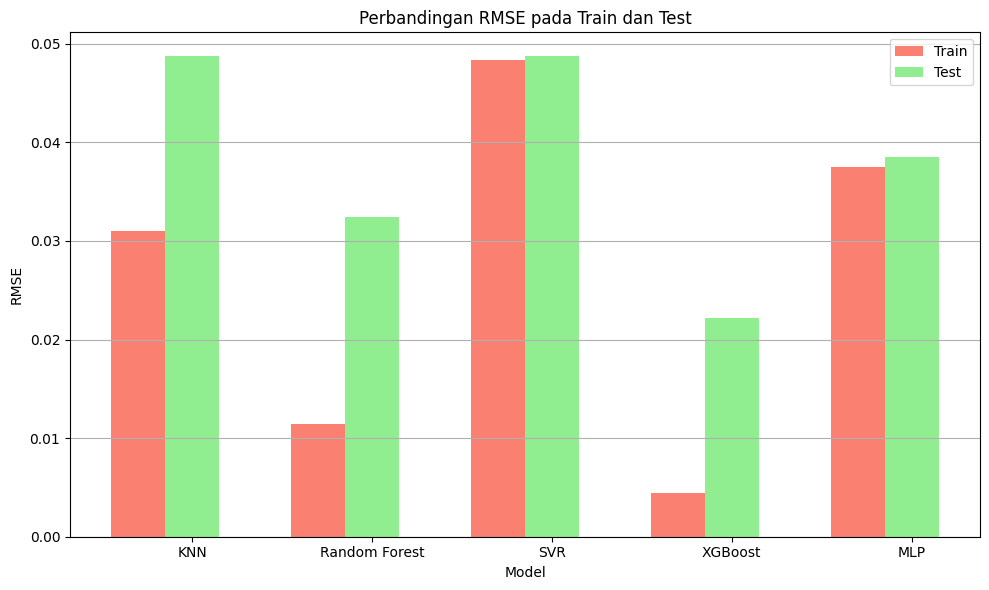

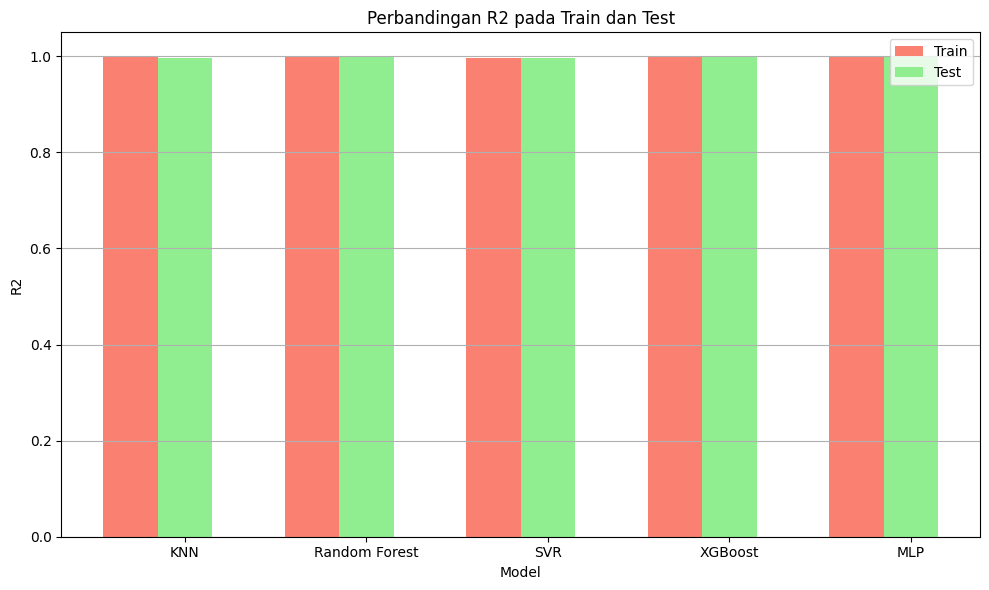

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Buat list metric dan dataset
metrics = ['MAE', 'RMSE', 'R2']
datasets = ['Train', 'Test']
colors = ['salmon', 'lightgreen']

# Loop setiap metric
for metric in metrics:
    plt.figure(figsize=(10,6))

    models = all_results['Model'].unique()
    x = np.arange(len(models))
    width = 0.3

    for i, dataset in enumerate(datasets):
        subset = all_results[all_results['Dataset'] == dataset]
        plt.bar(
            x + (i - 1) * width,
            subset[metric],
            width=width,
            label=dataset,
            color=colors[i]
        )

    plt.xticks(x, models)
    plt.title(f'Perbandingan {metric} pada Train dan Test')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


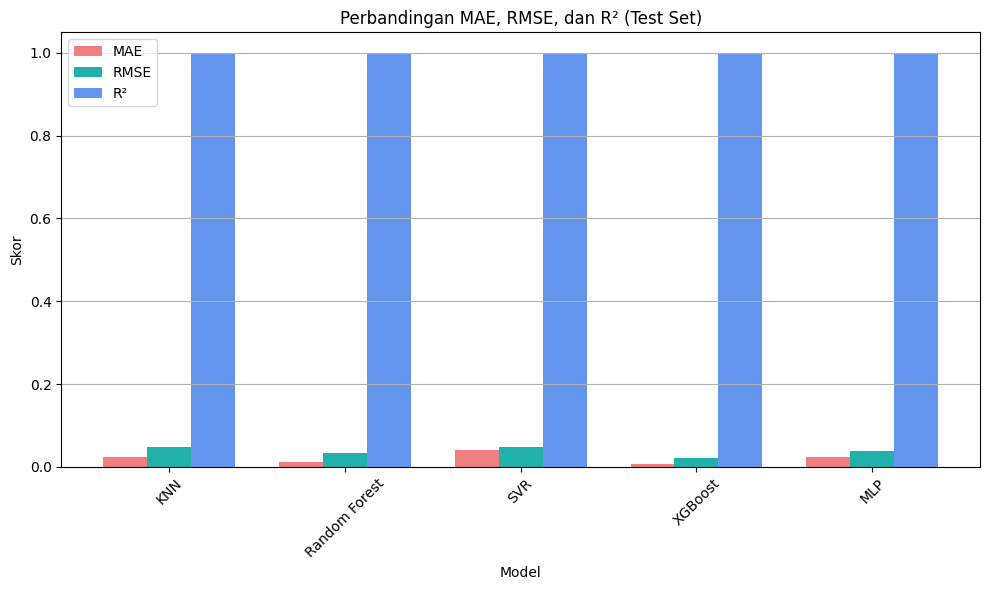

In [ ]:
import numpy as np

# Grouped Bar Chart untuk MAE, RMSE, R2 di Test Set
x = np.arange(len(test_results['Model']))
width = 0.25  # lebar batang

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width, test_results['MAE'], width, label='MAE', color='lightcoral')
rects2 = ax.bar(x, test_results['RMSE'], width, label='RMSE', color='lightseagreen')
rects3 = ax.bar(x + width, test_results['R2'], width, label='R²', color='cornflowerblue')

ax.set_xlabel('Model')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan MAE, RMSE, dan R² (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(test_results['Model'])
ax.legend()
ax.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


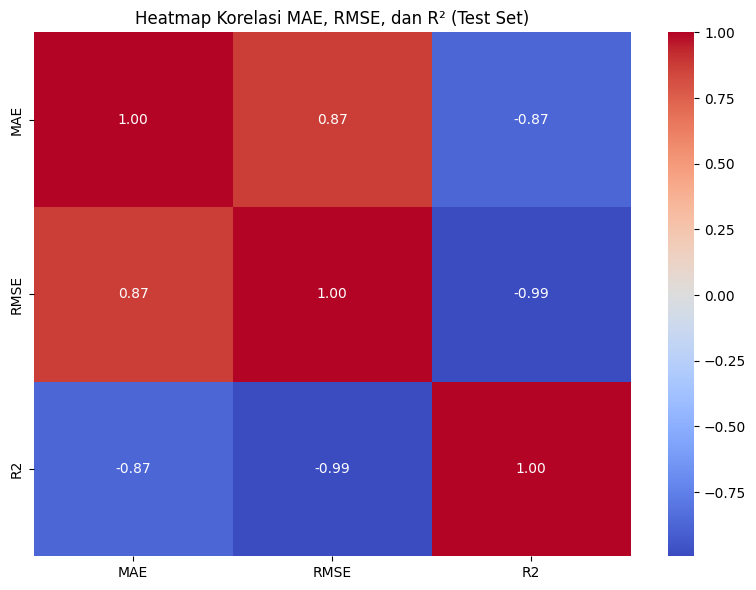

In [ ]:
import seaborn as sns

# Fokus hanya ke metrik
test_metrics_only = test_results[['MAE', 'RMSE', 'R2']].copy()
test_metrics_only.index = test_results['Model']  # Ganti index jadi Model

plt.figure(figsize=(8,6))
sns.heatmap(test_metrics_only.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi MAE, RMSE, dan R² (Test Set)')
plt.tight_layout()
plt.show()


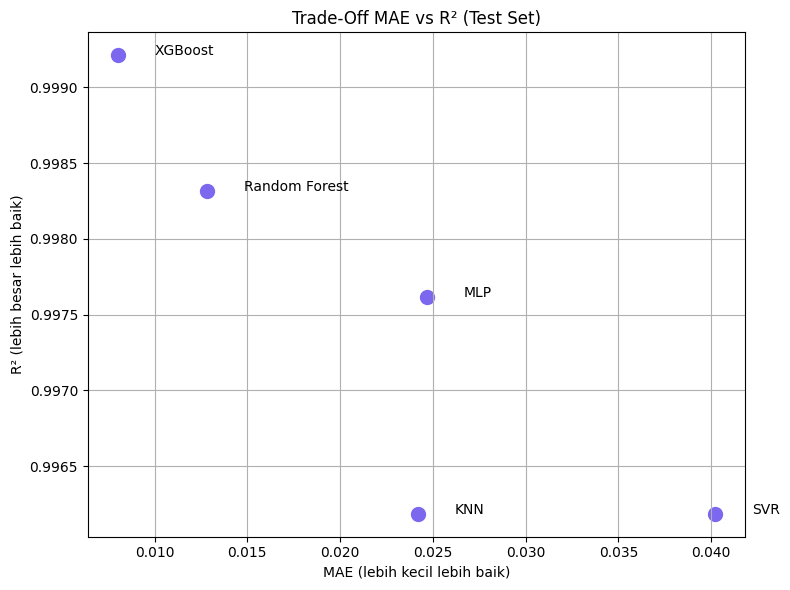

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(test_results['MAE'], test_results['R2'], s=100, color='mediumslateblue')

for i, model in enumerate(test_results['Model']):
    plt.text(test_results['MAE'].iloc[i]+0.002, test_results['R2'].iloc[i], model)

plt.xlabel('MAE (lebih kecil lebih baik)')
plt.ylabel('R² (lebih besar lebih baik)')
plt.title('Trade-Off MAE vs R² (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Prediction From Best Model

In [ ]:
import joblib
joblib.dump(best_xgb, "xgb_model.pkl")
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

### Manual Test

In [ ]:
import numpy as np
import pandas as pd
import joblib
from pythermalcomfort.models import pmv_ppd_ashrae
from sklearn.metrics import mean_absolute_error
import warnings

# Abaikan warning
warnings.filterwarnings("ignore", category=UserWarning)

# Muat model dan scaler
best_xgb = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler.pkl')

# Fungsi untuk prediksi
def predict_pmv(temperature, humidity, air_velocity, radiant_temp):
    # Buat array input
    input_data = np.array([[temperature, humidity, air_velocity, radiant_temp]])

    # Scaling data
    input_scaled = scaler.transform(input_data)

    # Prediksi dengan XGBoost
    pmv_xgb = best_xgb.predict(input_scaled)[0]

    # Hitung dengan rumus ASHRAE
    pmv_ashrae = pmv_ppd_ashrae(
        tdb=temperature,
        tr=radiant_temp,
        vr=air_velocity,
        rh=humidity,
        met=1.2,
        clo=0.5
    )['pmv']

    return {
        'Input': {
            'Temperature (°C)': temperature,
            'Humidity (%)': humidity,
            'Air Velocity (m/s)': air_velocity,
            'Radiant Temp (°C)': radiant_temp
        },
        'PMV_XGBoost': round(pmv_xgb, 4),
        'PMV_ASHRAE': round(pmv_ashrae, 4),
        'Difference': round(abs(pmv_xgb - pmv_ashrae), 4)
    }

# Contoh penggunaan (Anda bisa mengubah nilai-nilai ini)
sample_input = {
    'temperature': 28.0,    # Suhu udara (°C)
    'humidity': 50.0,       # Kelembaban relatif (%)
    'air_velocity': 0.1,    # Kecepatan udara (m/s)
    'radiant_temp': 28.0    # Suhu radian (°C)
}

# Lakukan prediksi
result = predict_pmv(**sample_input)

# Tampilkan hasil
print("\n=== Hasil Prediksi PMV ===")
for key, value in result['Input'].items():
    print(f"{key}: {value}")

print("\n=== Perbandingan Metode ===")
print(f"PMV (XGBoost): {result['PMV_XGBoost']}")
print(f"PMV (ASHRAE): {result['PMV_ASHRAE']}")
print(f"Selisih: {result['Difference']}")


=== Hasil Prediksi PMV ===
Temperature (°C): 28.0
Humidity (%): 50.0
Air Velocity (m/s): 0.1
Radiant Temp (°C): 28.0

=== Perbandingan Metode ===
PMV (XGBoost): 0.9894999861717224
PMV (ASHRAE): 0.99
Selisih: 0.0005


## Feature Importance (Tambahan)

       feature  mean_importance       std
0  temperature         0.749338  0.005992
3          mrt         0.506746  0.004908
2     air_flow         0.196458  0.003173
1     humidity         0.028312  0.000494


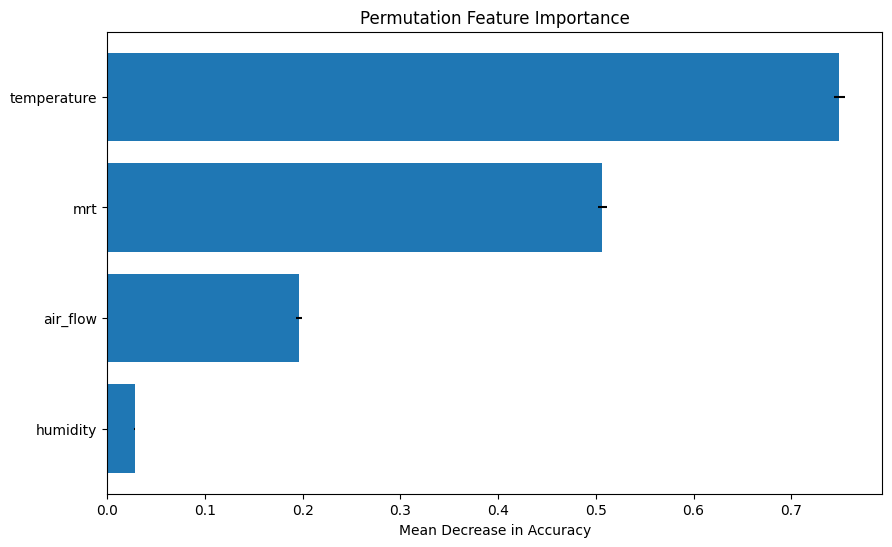

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(best_xgb, X_test_scaled, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    "feature": X_test.columns,
    "mean_importance": result.importances_mean,
    "std": result.importances_std
}).sort_values(by="mean_importance", ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['mean_importance'], xerr=importance_df['std'])
plt.xlabel("Mean Decrease in Accuracy")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()

